<a href="https://colab.research.google.com/github/williamsdoug/CTG_RP/blob/master/CTG_RP_Train_Model_Late.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Datasets and Train Model

In [1]:
#! rm -R images
! ls

basic_denoise.py     ctg_utils.py		    libRP.py	 test.py
compute_metadata.py  ctu-uhb-ctgdb		    __pycache__
config_local.py      generate_recurrence_images.py  sample_data


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import config_local
from config_local import *

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import gc

from fastai.vision import *
from fastai.metrics import error_rate

import torch
from torch import nn


import collections
import pprint
import random

In [0]:
from compute_metadata import get_splits, generate_label_file, generate_lists
from generate_recurrence_images import generate_rp_images, gen_recurrence_params

## Code

## Config

In [6]:
np.random.seed(1234)
random.seed(1234)

# Configure Recurrent Plot Parameters

POLICY='late_valid' # 'best_quality', 'early_valid', 'late_valid'

rp_params = gen_recurrence_params(dimensions=[2], time_delays=[1], percentages=[1,3, 10], use_clip_vals=[False])
rp_params

[{'dimension': 2, 'percentage': 1, 'time_delay': 1, 'use_clip': False},
 {'dimension': 2, 'percentage': 3, 'time_delay': 1, 'use_clip': False},
 {'dimension': 2, 'percentage': 10, 'time_delay': 1, 'use_clip': False}]

In [0]:
tfms=[]
size=64
bs=64
workers=4

path = Path() / 'images'

## Generate Recurrence Images


Record: 1001  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min


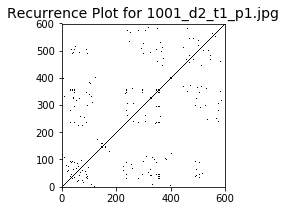


Record: 1002  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min


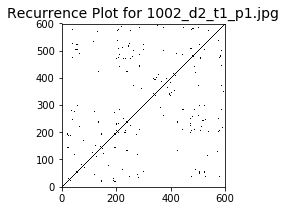

In [8]:
generate_rp_images(RECORDINGS_DIR, images_dir=IMAGES_DIR, rp_params=rp_params[:1], 
                   policy=POLICY,
                   show_signal=False, show_image=True, verbose=True, cmap='binary',
                   limit=3,
                  )

In [9]:
generate_rp_images(RECORDINGS_DIR, images_dir=IMAGES_DIR, rp_params=rp_params, 
                   policy=POLICY,
                   show_signal=False, show_image=False, verbose=True, cmap='binary',
                  )


Record: 1001  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1002  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1003  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1004  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1005  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1006  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1007  Samples: 15600   Duration: 65.0 min   Stage.II: 5 min

Record: 1008  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1009  Samples: 20400   Duration: 85.0 min   Stage.II: 25 min

Record: 1010  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1011  Samples: 15600   Duration: 65.0 min   Stage.II: 5 min

Record: 1012  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1013  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1014  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1015  Samples

In [0]:
#!ls images

## Generate Train and Valid Label Files

In [0]:
train_valid_groups_full = get_splits(image_dir='images', image_file='rp_images_index.json', 
                                     exclude=['_clipped'],
                                     thresh = 7.15)
              
# Create valid_x.csv files for each split
for i in range(len(train_valid_groups_full)):
    generate_lists(train_valid_groups_full[i], train_file='train_{}.csv'.format(i),
                   valid_file='valid_{}.csv'.format(i))

In [12]:
!ls images/*.csv

images/train_0.csv  images/train_3.csv	images/valid_1.csv  images/valid_4.csv
images/train_1.csv  images/train_4.csv	images/valid_2.csv
images/train_2.csv  images/valid_0.csv	images/valid_3.csv


In [0]:
train = ImageList.from_csv(path, 'train_0.csv')
valid = ImageList.from_csv(path, 'valid_0.csv')

lls = ItemLists(path, train, valid).label_from_df(cols=1).transform(tfms, size=size) 
#db = lls.databunch(bs=bs, num_workers=workers)#.normalize(binary_image_stats)
db = lls.databunch(bs=bs, num_workers=workers)
my_stats = db.batch_stats()
db = lls.databunch(bs=bs, num_workers=workers).normalize(my_stats)

In [14]:
db.batch_stats()

[tensor([0.0131, 0.0131, 0.0131]), tensor([1.0568, 1.0568, 1.0568])]

### Examine Results

In [15]:
print('nClass: {}    classes: {}'.format(db.c, db.classes))
db

nClass: 2    classes: [0, 1]


ImageDataBunch;

Train: LabelList (492 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: images;

Valid: LabelList (120 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: images;

Test: None

492 torch.Size([599, 599])


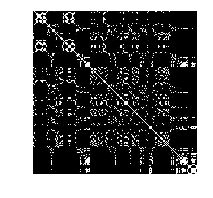

In [16]:
im = train.get(-1)
print(len(train), im.size)
im.show()

## Model

In [0]:
trial_model = nn.Sequential(
    nn.Sequential(
          nn.Conv2d(3,8,5),     # 60 × 60 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 29 × 29 × 8
        
          #nn.Dropout(p=0.25),
          nn.Conv2d(8,8,5),         # 25 × 25 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 12 × 12 × 8
        
          Flatten()         # 1152
    ),
    # removed model head to compute flatten size
)

In [18]:
trial_learn = Learner(db, trial_model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
trial_learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 60, 60]          608        True      
______________________________________________________________________
ReLU                 [8, 60, 60]          0          False     
______________________________________________________________________
AvgPool2d            [8, 29, 29]          0          False     
______________________________________________________________________
Conv2d               [8, 25, 25]          1,608      True      
______________________________________________________________________
ReLU                 [8, 25, 25]          0          False     
______________________________________________________________________
AvgPool2d            [8, 12, 12]          0          False     
______________________________________________________________________
Flatten              [1152]               0          False     
______________________________________________________________

In [19]:
del trial_model
trial_learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [0]:
mymodel = nn.Sequential(
    nn.Sequential(
          nn.Conv2d(3,8,5),     # 60 × 60 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 29 × 29 × 8
        
          #nn.Dropout(p=0.25),
          nn.Conv2d(8,8,5),         # 25 × 25 × 8
          nn.ReLU(),
          nn.AvgPool2d(3, stride=2),    # 12 × 12 × 8
        
          Flatten()         # 1152
    ),
    nn.Sequential(
#           nn.Dropout(p=0.25),
          nn.Linear(1152, 144),
          nn.ReLU(),
          nn.Dropout(p=0.8),
          nn.Linear(144, db.c) 
    )
)

In [0]:
learn = Learner(db, mymodel, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.summary()
learn.save('initial')

# Train Model

In [22]:
learn.fit_one_cycle(1, 1e-6)  # learn.fit_one_cycle(1, 0.01)

# learn.save('save-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.693886,0.692510,0.516667,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


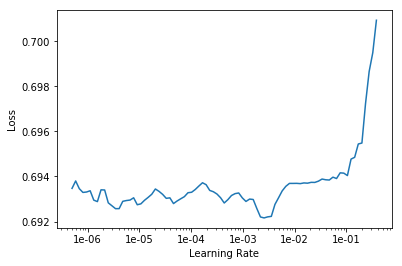

In [23]:
learn.lr_find(end_lr=1)
learn.recorder.plot()

In [24]:
learn.load('initial')
learn.fit_one_cycle(100, 3e-3)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.695284,0.692482,0.516667,00:04
1,0.693915,0.692500,0.541667,00:04
2,0.693607,0.692465,0.516667,00:03
3,0.693084,0.692320,0.508333,00:03
4,0.692706,0.692311,0.541667,00:03
5,0.692037,0.692226,0.500000,00:03
6,0.691179,0.691299,0.541667,00:03
7,0.690574,0.690949,0.500000,00:03
8,0.689546,0.687827,0.533333,00:03
9,0.688980,0.684806,0.575000,00:03


In [25]:
learn.load('initial')
learn.fit_one_cycle(100, 1e-2)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.696629,0.692615,0.500000,00:03
1,0.694727,0.692235,0.533333,00:03
2,0.693385,0.692894,0.541667,00:03
3,0.691462,0.693684,0.500000,00:03
4,0.690492,0.692586,0.525000,00:03
5,0.691972,0.692593,0.508333,00:03
6,0.693244,0.691971,0.508333,00:03
7,0.692680,0.690610,0.558333,00:03
8,0.692178,0.688847,0.550000,00:03
9,0.691455,0.688650,0.541667,00:03


In [26]:
learn.load('initial')
learn.fit_one_cycle(100, 1e-3)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.692733,0.692579,0.508333,00:04
1,0.694625,0.692652,0.516667,00:03
2,0.693941,0.692659,0.500000,00:03
3,0.693326,0.692593,0.508333,00:03
4,0.693604,0.692623,0.516667,00:04
5,0.693174,0.692622,0.500000,00:04
6,0.693262,0.692637,0.516667,00:03
7,0.692603,0.692415,0.533333,00:03
8,0.692009,0.691837,0.533333,00:03
9,0.691222,0.691770,0.525000,00:03


In [27]:
learn.load('initial')
learn.fit_one_cycle(100, 1e-4)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.693613,0.692511,0.516667,00:03
1,0.693414,0.692514,0.516667,00:03
2,0.693848,0.692519,0.516667,00:03
3,0.693175,0.692522,0.508333,00:03
4,0.692865,0.692522,0.508333,00:03
5,0.692726,0.692523,0.508333,00:03
6,0.693363,0.692528,0.516667,00:03
7,0.692880,0.692523,0.516667,00:03
8,0.692528,0.692506,0.525000,00:03
9,0.692832,0.692463,0.508333,00:03


In [28]:
#train an additional 100 epochs
learn.fit_one_cycle(100, 1e-4)  # learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.634672,0.679086,0.558333,00:03
1,0.638939,0.679118,0.558333,00:04
2,0.639012,0.679185,0.558333,00:04
3,0.637452,0.679208,0.558333,00:03
4,0.635154,0.679166,0.558333,00:03
5,0.637012,0.679190,0.558333,00:03
6,0.635458,0.679081,0.558333,00:03
7,0.635778,0.679039,0.558333,00:03
8,0.638676,0.679133,0.566667,00:03
9,0.639000,0.679200,0.566667,00:03


In [29]:
gc.collect()

220